<a href="https://colab.research.google.com/github/paascorb/Pruebas-TFM/blob/main/PruebasResponderPreguntasHuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pruebas responder preguntas sobre texto huggingface

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = 'mrm8488/spanish-t5-small-sqac-for-qa'
tokenizer = AutoTokenizer.from_pretrained(ckpt)
model = T5ForConditionalGeneration.from_pretrained(ckpt).to(device)



def get_answer(question, context):
  input_text = 'question: %s  context: %s' % (question, context)
  features = tokenizer([input_text ], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
  output = model.generate(input_ids=features['input_ids'].to(device), 
               attention_mask=features['attention_mask'].to(device))
  return tokenizer.decode(output[0], skip_special_tokens=True)
  
context = '''
La ex codirectora del grupo de investigación de IA ética de Google, Margaret Mitchell, 
quien fue despedida en febrero después de una controversia sobre un artículo crítico del que fue coautora, 
se unirá a HuggingFace para ayudar a que los algoritmos de IA sean más justos.
'''

question = '¿Qué hará Margaret Mitchell en HuggingFace?'

print(get_answer(context, question))

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


ayudar a que los algoritmos de ia sean más justos


Prueba sacada de: https://huggingface.co/mrm8488/spanish-t5-small-sqac-for-qa

Buscando en otro artículo de hggingface: https://huggingface.co/IIC/beto-base-spanish-sqac

Vemos que no consigue dar una respuesta solo entrena el modelo y saca los outputs, pero no lo decodifica, vamos a hacerlo.

In [3]:
from transformers import RobertaTokenizer, RobertaForQuestionAnswering
import torch

tokenizer = RobertaTokenizer.from_pretrained("IIC/roberta-base-spanish-sqac")
model = RobertaForQuestionAnswering.from_pretrained("IIC/roberta-base-spanish-sqac")

question, text = "Quién es el padre de Luke Skywalker?", "En la famosa película, Darth Veider le dice a Luke Skywalker aquella frase que todos recordamos: yo soy tu padre."
inputs = tokenizer(question, text, return_tensors="pt")
start_positions = torch.tensor([1])
end_positions = torch.tensor([3])

outputs = model(**inputs, start_positions=start_positions, end_positions=end_positions)
loss = outputs.loss
start_scores = outputs.start_logits
end_scores = outputs.end_logits

In [4]:
predicted_start_idx = start_scores.argmax(-1).item()
predicted_end_idx = end_scores.argmax(-1).item()

# decodificamos
predicted_answer = tokenizer.decode(inputs.input_ids.squeeze()[predicted_start_idx : predicted_end_idx + 1])
print(predicted_answer)

 Darth Veider


Ahora vamos a modificar el texto y la pregunta para nuestro tema.

Probamos primero el último modelo.

In [5]:
from transformers import RobertaTokenizer, RobertaForQuestionAnswering
import torch

tokenizer = RobertaTokenizer.from_pretrained("IIC/roberta-base-spanish-sqac")
model = RobertaForQuestionAnswering.from_pretrained("IIC/roberta-base-spanish-sqac")

question, text = "¿Cuántos suicidios se registraron en España en 2020?", """En el mundo, el suicidio se cobra más vidas que las guerras y los homicidios juntos: en torno a las 700.000 muertes al año. 
                                                          Solo en España, en 2020 se registró la cifra histórica de 3.941 defunciones por este motivo: una media de 11 al día; una cada dos horas y cuarto. 
                                                          Sin embargo, su prevención está lejos de ser una prioridad política, social, mediática o sanitaria. En parte, para romper esa inercia se creó 
                                                          la Fundación Española para la Prevención del Suicidio, que desde el primer momento ha apostado decididamente por desarrollar acciones para 
                                                          la prevención del suicidio, como las que conforman su programa 'Prevensuic. Hablar es prevenir'."""
inputs = tokenizer(question, text, return_tensors="pt")
start_positions = torch.tensor([1])
end_positions = torch.tensor([3])

outputs = model(**inputs, start_positions=start_positions, end_positions=end_positions)
loss = outputs.loss
start_scores = outputs.start_logits
end_scores = outputs.end_logits

predicted_start_idx = start_scores.argmax(-1).item()
predicted_end_idx = end_scores.argmax(-1).item()

# decodificamos
predicted_answer = tokenizer.decode(inputs.input_ids.squeeze()[predicted_start_idx : predicted_end_idx + 1])
print(predicted_answer)

 3.941


Perfecto, vemos que ha respondido perfectamente, entendiendo bien el contexto.

Ahora vamos a probar el otro modelo, el primero que hemos usado.

In [6]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = 'mrm8488/spanish-t5-small-sqac-for-qa'
tokenizer = AutoTokenizer.from_pretrained(ckpt)
model = T5ForConditionalGeneration.from_pretrained(ckpt).to(device)



def get_answer(question, context):
  input_text = 'question: %s  context: %s' % (question, context)
  features = tokenizer([input_text ], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
  output = model.generate(input_ids=features['input_ids'].to(device), 
               attention_mask=features['attention_mask'].to(device))
  return tokenizer.decode(output[0], skip_special_tokens=True)
  
context = '''
En el mundo, el suicidio se cobra más vidas que las guerras y los homicidios juntos: en torno a las 700.000 muertes al año. 
Solo en España, en 2020 se registró la cifra histórica de 3.941 defunciones por este motivo: una media de 11 al día; una cada dos horas y cuarto. 
Sin embargo, su prevención está lejos de ser una prioridad política, social, mediática o sanitaria. En parte, para romper esa inercia se creó 
la Fundación Española para la Prevención del Suicidio, que desde el primer momento ha apostado decididamente por desarrollar acciones para 
la prevención del suicidio, como las que conforman su programa 'Prevensuic. Hablar es prevenir'.
'''

question = '¿Cuántos suicidios se registraron en España en 2020?'

print(get_answer(context, question))

3.941


Vemos que funciona perfectamente. Como última prueba, voy a tratar de transformar un PDF a texto, pasarselo y ver si conseguimos que responda bien alguna preguntilla.

https://stackoverflow.com/questions/34837707/how-to-extract-text-from-a-pdf-file
Librerias sobre extracción de texto de PDF.

In [7]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from PyPDF2 import PdfReader

reader = PdfReader('AVALIA-T 2012 -GPC Conducta Suicida  (Anexo 1 Informacion para pacientes y familiares)-.pdf')
text = ""
for page in reader.pages:
    text += page.extract_text() + "\n"

In [9]:
text

' \n \n \nLA CONDUCTA SUICIDA  \n \nInformación para pacientes, familiares y allegados  \n \n \n  \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n  \n \n \n \n \n \n \n \n \n \n\n \navalia -t | 2  \n \n \nEsta información ha sido elaborada a partir del conocimiento basado en la literatura \ncientífica disponible en el momento de la publicación.  \n \n \n \n \n \n \n \n \nAutoría  \n \nGrupo de Trabajo de la Guía de Práctica Clínica de Prevención y Tratamiento de la \nConducta Suicida. Guía de Práctica Clínica de Prevención y Tratamiento de la Conducta \nSuicida. Madrid: Ministerio de Sanidad, Política Social e Igualdad. Axencia de  Avaliación \nde Tecnoloxías Sanitarias de Galicia (avalia -t); 2010. Guías de Práctica Clínica en el SNS: \navalia - t Nº 2010/02.  \n \n \nAgradecimientos  \n \nEl grupo elaborador de la Guía de Práctica Clínica desea dar las gracias a José Luis Iglesias \nDiz y a Luis Igle sias Fernández, autores de las ilustraciones y de forma especial a todos los \npacien

Vamos a eliminar caracteres raros.

In [10]:
import re

text_clean = re.sub(r'[^a-zA-Z0-9\:;.,_-_ÑñÁáÉéÍíÓóÚú ]', ' ', text)
text_clean.lower()

'      la conducta suicida     información para pacientes, familiares y allegados                                                                avalia  t   2       esta información ha sido elaborada a partir del conocimiento basado en la literatura  científica disponible en el momento de la publicación.                   autoría     grupo de trabajo de la guía de práctica clínica de prevención y tratamiento de la  conducta suicida. guía de práctica clínica de prevención y tratamiento de la conducta  suicida. madrid: ministerio de sanidad, política social e igualdad. axencia de  avaliación  de tecnoloxías sanitarias de galicia  avalia  t ; 2010. guías de práctica clínica en el sns:  avalia   t n  2010 02.       agradecimientos     el grupo elaborador de la guía de práctica clínica desea dar las gracias a josé luis iglesias  diz y a luis igle sias fernández, autores de las ilustraciones y de forma especial a todos los  pacientes y familiares que han colaborado en la elaboración de este 

Hemos conseguido parsear el pdf entero a texto legible, veamos si los modelos nos pueden responder a alguna preguntilla.

In [15]:
question = "¿Qué hacer ante la posible conducta suicida?"
def get_answer_ext(question, context):
  input_text = 'question: %s  context: %s' % (question, context)
  features = tokenizer([input_text ], padding='max_length', truncation=True, max_length=1024, return_tensors='pt')
  output = model.generate(input_ids=features['input_ids'].to(device), 
               attention_mask=features['attention_mask'].to(device))
  return tokenizer.decode(output[0], skip_special_tokens=True)
print(get_answer_ext(text_clean.lower(), question))

el suicidio


Esto es malo, vamos a hacerle otras preguntas, a ver como reacciona.

In [19]:
question = "¿Cuál es el teléfono de urgencias?"
print(get_answer(text_clean.lower(), question))

la conducta suicida


Entiendo que le cuesta determinar las respuestas corresctas, ya que no tenemos la estructura de un texto clásico, que será del que han aprendido estos modelos. Por ejemplo, la respuesta que esperaba era la siguiente:

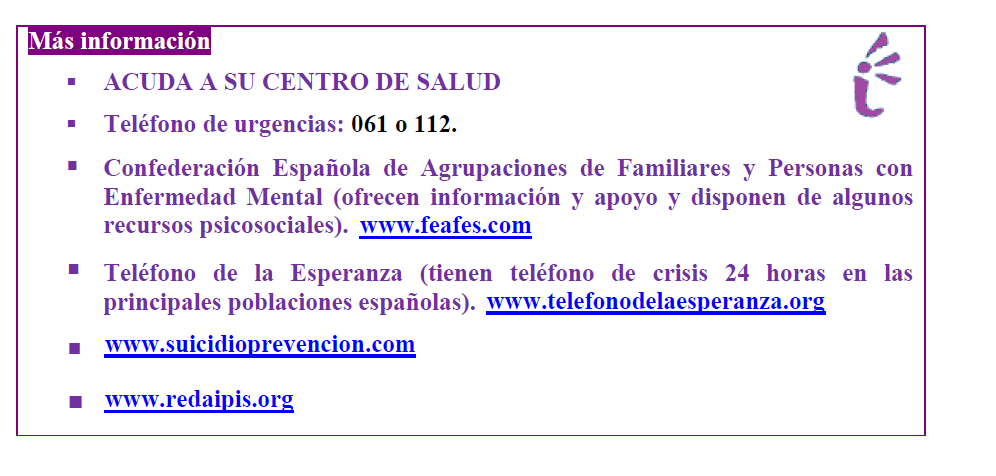

Vemos que como no hay comas, puntos ni nada el parseador de texto habrá juntado todo, lo cual es lógico y el modelo no conseguirá entenderlo bien.

In [20]:
question='¿Qué puede hacer usted si ha comenzado a pensar en el suicidio?'
print(get_answer(text_clean.lower(), question))

la conducta suicida


In [21]:
question='¿Algunos ejemplos de sucesos que pueden actuar como precipitantes?'
print(get_answer(text_clean.lower(), question))

la conducta suicida


Vamos a probar con otro PDF.

In [22]:
from PyPDF2 import PdfReader

reader = PdfReader('SaludMadrid 2014 Guia de Autoayuda.pdf')
text = ""
for page in reader.pages:
    text += page.extract_text() + "\n"
text

'GuiaAutoay_PrevSuicidio_16pags_OK.indd   1GuiaAutoay_PrevSuicidio_16pags_OK.indd   1 29/10/13   14:01:4629/10/13   14:01:46\nALGUNOS DATOS IMPORTANTES SOBRE LA IDEACIÓN Y LA CONDUCTA SUICIDA\nLa Organización Mundial de la Salud (OMS), identifi  ca el suicidio y sus intentos \ncomo uno de los problemas más graves de salud que pueden afectar a las perso-nas, y es por ello que recomienda a todos sus estados miembros que sea atendido de forma prioritaria. \nAsí pues, el objetivo que perseguimos con esta Guía es proporcionar informa-\nción v\neraz y objetiva sobre la conducta suicida, ayudar a identifi  car cuáles son \nlas señales de aler\nta y proponer distintas habilidades de afrontamiento validadas \npara su pronta identifi  cación y prevención.Esperamos que el contenido de esta Guía resulte de gran ayuda para todas las per-\nsonas afectadas por ideas de suicidio.\nEl suicidio es una solución eterna para lo que \na menudo no es más que un problema temporal\n Edwin Shneidman, 1985 \nGui

In [23]:
import re

text_clean = re.sub(r'[^a-zA-Z0-9\:;.,_-_ÑñÁáÉéÍíÓóÚú ]', ' ', text)
text_clean.lower()

'guiaautoay_prevsuicidio_16pags_ok.indd   1guiaautoay_prevsuicidio_16pags_ok.indd   1 29 10 13   14:01:4629 10 13   14:01:46 algunos datos importantes sobre la ideación y la conducta suicida la organización mundial de la salud  oms , identifi  ca el suicidio y sus intentos  como uno de los problemas más graves de salud que pueden afectar a las perso nas, y es por ello que recomienda a todos sus estados miembros que sea atendido de forma prioritaria.  así pues, el objetivo que perseguimos con esta guía es proporcionar informa  ción v eraz y objetiva sobre la conducta suicida, ayudar a identifi  car cuáles son  las señales de aler ta y proponer distintas habilidades de afrontamiento validadas  para su pronta identifi  cación y prevención.esperamos que el contenido de esta guía resulte de gran ayuda para todas las per  sonas afectadas por ideas de suicidio. el suicidio es una solución eterna para lo que  a menudo no es más que un problema temporal  edwin shneidman, 1985  guiaautoay_prevsu

In [25]:
question='¿Qué estima la Organización Mundial de la Salud?'
print(get_answer(text_clean.lower(), question))

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


se consuma un suicidio


Vamos a probar el otro modelo mejor.

In [27]:
from transformers import RobertaTokenizer, RobertaForQuestionAnswering
import torch

tokenizer = RobertaTokenizer.from_pretrained("IIC/roberta-base-spanish-sqac")
model = RobertaForQuestionAnswering.from_pretrained("IIC/roberta-base-spanish-sqac")

inputs = tokenizer(question, text_clean.lower(), return_tensors="pt", truncation=True)
start_positions = torch.tensor([1])
end_positions = torch.tensor([3])

outputs = model(**inputs, start_positions=start_positions, end_positions=end_positions)
loss = outputs.loss
start_scores = outputs.start_logits
end_scores = outputs.end_logits

predicted_start_idx = start_scores.argmax(-1).item()
predicted_end_idx = end_scores.argmax(-1).item()

# decodificamos
predicted_answer = tokenizer.decode(inputs.input_ids.squeeze()[predicted_start_idx : predicted_end_idx + 1])
print(predicted_answer)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Hay tanto texto que le abruma, vamos a volver a coger preguntillas cortas, solo por probarlo un poquito más.

In [29]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = 'mrm8488/spanish-t5-small-sqac-for-qa'
tokenizer = AutoTokenizer.from_pretrained(ckpt)
model = T5ForConditionalGeneration.from_pretrained(ckpt).to(device)



def get_answer(question, context):
  input_text = 'question: %s  context: %s' % (question, context)
  features = tokenizer([input_text ], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
  output = model.generate(input_ids=features['input_ids'].to(device), 
               attention_mask=features['attention_mask'].to(device))
  return tokenizer.decode(output[0], skip_special_tokens=True)
  
context = '''
La conducta suicida es un problema exclusivamente humano, multicausal y multifactorial. 
Además de factores biológicos (genéticos u otros), intervienen multitud de factores sociales, culturales, personales, familiares, etc., 
lo que, además de producir la gran variabilidad epidemiológica que existe entre países, regiones y localidades, la hace especialmente compleja de entender y de abordar.

No sabemos por qué se suicidan las personas, al igual que no sabemos por qué se deprimen o por qué padecen cáncer. 
Eso no significa que no sepamos cómo prevenirlo. La Fundación Española para la Prevención del Suicidio intenta ayudar a ello.

Sobre la conducta suicida, sobre quienes la padecen e, incluso, sobre su entorno próximo, 
existe un estigma histórico que hay que ir rompiendo (al igual que se ha ido haciendo con otros tantos tabúes sociales). 
Estos prejuicios, que dificultan enormemente la adecuada detección y abordaje del riesgo suicida, junto con las señales de alerta 
y los factores precipitante son lo que se pueden consultar en esta sección de la web y en la app Prevensuic.
'''

question = '¿Qué interviene en la conducta suicida?'

print(get_answer(context, question))

multitud de factores sociales, culturales, culturales, personales, familiares, etc.


Cuando recibe poco contexto y claro puede resolver preguntas bastante bien.

In [30]:
question = '¿Por qué se suicidan las personas?'

print(get_answer(context, question))

se deprimen o por qué padecen cáncer


Esta no la ha entendido tan bien.

In [32]:
question = '¿Qué se puede consultar en esta sección de la web y en la app Prevensuic?'

print(get_answer(context, question))

la fundación española para la prevención del suicidio


Preguntas sencillas y directas muchas veces la entiende, otras se vuelve loco, con esto acabamos estas pruebas.